Model variation with residual connections

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorboard
from PIL import Image
import os
from datetime import datetime
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, Flatten

2023-03-10 21:50:43.571117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 21:50:43.878642: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 21:50:44.012367: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 21:50:44.720573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2023-03-10 21:50:45.880454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:50:45.920318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:50:45.920658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:50:45.925248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [3]:
from data_processing import processing

train_data, test_data, class_names = processing("data/ColorfulOriginal/")

Found 721 files belonging to 20 classes.
Using 649 files for training.
Using 72 files for validation.
classes:  ['Apple', 'Banana', 'Brinjal', 'Broccoli', 'CapsicumGreen', 'Carrot', 'Cherry', 'ChilliGreen', 'Corn', 'Cucumber', 'LadyFinger', 'Lemon', 'Orange', 'Peach', 'Pear', 'Plum', 'Pomegranate', 'Potato', 'Strawberry', 'Tomato']
data example:  <PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int32, name=None))>


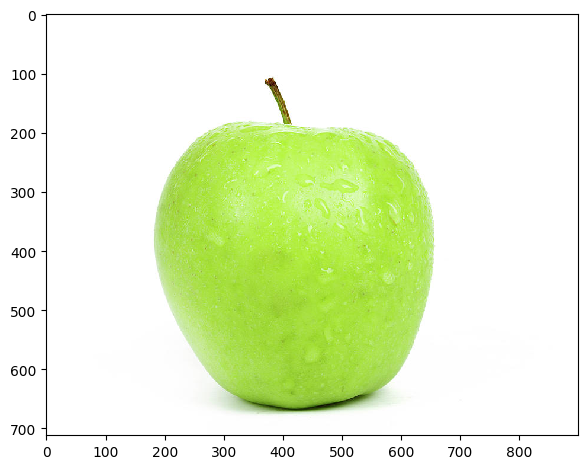

In [4]:
sample_image = imread("data/ColorfulOriginal/Apple/Apple1.jpg")/255
imshow(sample_image)

In [5]:
# check if images have same min and max values
sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
sample_image = tfio.experimental.color.rgb_to_lab(sample_image)

print(tf.reduce_min(sample_image[0]), tf.reduce_max(sample_image[0]))
print(tf.reduce_min(sample_image[1]), tf.reduce_max(sample_image[1]))
print(tf.reduce_min(sample_image[2]), tf.reduce_max(sample_image[2]))

tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)


2023-03-10 21:50:48.317117: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
from Models import Only_Colorization_Model, Only_Classification_Model, Model
from Visualization import visualize
from Training import training_loop, training_loop_classification, training_loop_colorization

In [10]:
# train and test multi-task model
epochs = 150
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

model00001= Model(optimizer=optimizer, loss_function_color=loss_function_color, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/colorful/resnet/Adam0.00001/train"
test_log_path = f"logs/{current_time}/colorful/resnet/Adam0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop(model00001, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


100%|██████████| 41/41 [01:03<00:00,  1.56s/it]


Epoch:  1
Loss Color:  0.023679467 (Train)
Loss Category:  0.01498028 (Train)
Accuracy:  0.07550077 (Train)
Top-5-Accuracy:  0.31432974 (Train)


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Loss Color:  0.03250858 (Test)
Loss Category:  0.0154433595 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Epoch:  2
Loss Color:  0.010645974 (Train)
Loss Category:  0.014749998 (Train)
Accuracy:  0.08012327 (Train)
Top-5-Accuracy:  0.36363637 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


Loss Color:  0.023390295 (Test)
Loss Category:  0.01611057 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:01<00:00,  1.50s/it]


Epoch:  3
Loss Color:  0.009427913 (Train)
Loss Category:  0.0145403305 (Train)
Accuracy:  0.104776576 (Train)
Top-5-Accuracy:  0.41448382 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


Loss Color:  0.01732042 (Test)
Loss Category:  0.016957747 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:01<00:00,  1.51s/it]


Epoch:  4
Loss Color:  0.009032032 (Train)
Loss Category:  0.014299791 (Train)
Accuracy:  0.11402157 (Train)
Top-5-Accuracy:  0.44375962 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


Loss Color:  0.019406227 (Test)
Loss Category:  0.022186771 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:02<00:00,  1.52s/it]


Epoch:  5
Loss Color:  0.008836585 (Train)
Loss Category:  0.013868371 (Train)
Accuracy:  0.1540832 (Train)
Top-5-Accuracy:  0.5146379 (Train)


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


Loss Color:  0.019993644 (Test)
Loss Category:  0.01962668 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Epoch:  6
Loss Color:  0.008267645 (Train)
Loss Category:  0.013650137 (Train)
Accuracy:  0.15100154 (Train)
Top-5-Accuracy:  0.5223421 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


Loss Color:  0.023997959 (Test)
Loss Category:  0.022662602 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Epoch:  7
Loss Color:  0.008050486 (Train)
Loss Category:  0.013454676 (Train)
Accuracy:  0.16795069 (Train)
Top-5-Accuracy:  0.5392912 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


Loss Color:  0.018691123 (Test)
Loss Category:  0.018266495 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  8
Loss Color:  0.007876497 (Train)
Loss Category:  0.01319226 (Train)
Accuracy:  0.18181819 (Train)
Top-5-Accuracy:  0.5577812 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Loss Color:  0.016764337 (Test)
Loss Category:  0.019209264 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.44s/it]


Epoch:  9
Loss Color:  0.007667612 (Train)
Loss Category:  0.012741882 (Train)
Accuracy:  0.22033899 (Train)
Top-5-Accuracy:  0.63174117 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Loss Color:  0.014226918 (Test)
Loss Category:  0.019627858 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  10
Loss Color:  0.0074273935 (Train)
Loss Category:  0.01257146 (Train)
Accuracy:  0.20801233 (Train)
Top-5-Accuracy:  0.6640986 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


Loss Color:  0.011001695 (Test)
Loss Category:  0.021177772 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:01<00:00,  1.49s/it]


Epoch:  11
Loss Color:  0.007383735 (Train)
Loss Category:  0.01234954 (Train)
Accuracy:  0.2650231 (Train)
Top-5-Accuracy:  0.6594761 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


Loss Color:  0.012075302 (Test)
Loss Category:  0.020471578 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  12
Loss Color:  0.007107757 (Train)
Loss Category:  0.01233165 (Train)
Accuracy:  0.21417566 (Train)
Top-5-Accuracy:  0.6640986 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.018713787 (Test)
Loss Category:  0.018761331 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  13
Loss Color:  0.0071737664 (Train)
Loss Category:  0.011969203 (Train)
Accuracy:  0.25731894 (Train)
Top-5-Accuracy:  0.6841294 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.013002354 (Test)
Loss Category:  0.021243595 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  14
Loss Color:  0.006884545 (Train)
Loss Category:  0.011752023 (Train)
Accuracy:  0.29121727 (Train)
Top-5-Accuracy:  0.7211094 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.02028575 (Test)
Loss Category:  0.020658478 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  15
Loss Color:  0.0069720754 (Train)
Loss Category:  0.011875477 (Train)
Accuracy:  0.26810476 (Train)
Top-5-Accuracy:  0.70878273 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.020473331 (Test)
Loss Category:  0.02082135 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  16
Loss Color:  0.0068748803 (Train)
Loss Category:  0.01177427 (Train)
Accuracy:  0.2650231 (Train)
Top-5-Accuracy:  0.6979969 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.011544014 (Test)
Loss Category:  0.025008798 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  17
Loss Color:  0.0067233574 (Train)
Loss Category:  0.011563675 (Train)
Accuracy:  0.29583976 (Train)
Top-5-Accuracy:  0.6933744 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.013683585 (Test)
Loss Category:  0.021248503 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  18
Loss Color:  0.006592336 (Train)
Loss Category:  0.011391855 (Train)
Accuracy:  0.28659475 (Train)
Top-5-Accuracy:  0.71340525 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.019958673 (Test)
Loss Category:  0.021272177 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  19
Loss Color:  0.006469628 (Train)
Loss Category:  0.011100609 (Train)
Accuracy:  0.30970725 (Train)
Top-5-Accuracy:  0.74730355 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.016089771 (Test)
Loss Category:  0.021379534 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  20
Loss Color:  0.0063775205 (Train)
Loss Category:  0.010972521 (Train)
Accuracy:  0.3081664 (Train)
Top-5-Accuracy:  0.78890604 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.012478764 (Test)
Loss Category:  0.023657434 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  21
Loss Color:  0.006405076 (Train)
Loss Category:  0.010957461 (Train)
Accuracy:  0.3174114 (Train)
Top-5-Accuracy:  0.7688752 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.014284256 (Test)
Loss Category:  0.024860738 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  22
Loss Color:  0.006381698 (Train)
Loss Category:  0.010750237 (Train)
Accuracy:  0.3081664 (Train)
Top-5-Accuracy:  0.7765794 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.0152749475 (Test)
Loss Category:  0.024814364 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  23
Loss Color:  0.0062939213 (Train)
Loss Category:  0.010616917 (Train)
Accuracy:  0.33590138 (Train)
Top-5-Accuracy:  0.7688752 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.016418394 (Test)
Loss Category:  0.023615953 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  24
Loss Color:  0.006332606 (Train)
Loss Category:  0.010651098 (Train)
Accuracy:  0.33436054 (Train)
Top-5-Accuracy:  0.78120184 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.013713665 (Test)
Loss Category:  0.023499394 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  25
Loss Color:  0.006123386 (Train)
Loss Category:  0.010219109 (Train)
Accuracy:  0.33436054 (Train)
Top-5-Accuracy:  0.8027735 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.01510666 (Test)
Loss Category:  0.027779559 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  26
Loss Color:  0.006189849 (Train)
Loss Category:  0.010653732 (Train)
Accuracy:  0.3266564 (Train)
Top-5-Accuracy:  0.76117104 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.01329682 (Test)
Loss Category:  0.021964956 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  27
Loss Color:  0.0061465413 (Train)
Loss Category:  0.010250623 (Train)
Accuracy:  0.32973805 (Train)
Top-5-Accuracy:  0.81510013 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.010133171 (Test)
Loss Category:  0.025927668 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.083333336 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  28
Loss Color:  0.006327454 (Train)
Loss Category:  0.010310596 (Train)
Accuracy:  0.34360555 (Train)
Top-5-Accuracy:  0.816641 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.016906615 (Test)
Loss Category:  0.025423199 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  29
Loss Color:  0.0059177703 (Train)
Loss Category:  0.009731961 (Train)
Accuracy:  0.3713405 (Train)
Top-5-Accuracy:  0.8412943 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.015895879 (Test)
Loss Category:  0.022789503 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  30
Loss Color:  0.0060077976 (Train)
Loss Category:  0.010070523 (Train)
Accuracy:  0.34976888 (Train)
Top-5-Accuracy:  0.807396 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.022363381 (Test)
Loss Category:  0.026077595 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  31
Loss Color:  0.005894036 (Train)
Loss Category:  0.010075982 (Train)
Accuracy:  0.35901386 (Train)
Top-5-Accuracy:  0.8104777 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.019432556 (Test)
Loss Category:  0.026930815 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  32
Loss Color:  0.0059110946 (Train)
Loss Category:  0.009477462 (Train)
Accuracy:  0.4175655 (Train)
Top-5-Accuracy:  0.82896763 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.013159332 (Test)
Loss Category:  0.023994217 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  33
Loss Color:  0.005811764 (Train)
Loss Category:  0.009697001 (Train)
Accuracy:  0.40061632 (Train)
Top-5-Accuracy:  0.816641 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.017231207 (Test)
Loss Category:  0.028038556 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  34
Loss Color:  0.005816512 (Train)
Loss Category:  0.009564218 (Train)
Accuracy:  0.36517718 (Train)
Top-5-Accuracy:  0.8305085 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.017104106 (Test)
Loss Category:  0.024367962 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.041666668 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  35
Loss Color:  0.0060512037 (Train)
Loss Category:  0.009962456 (Train)
Accuracy:  0.3605547 (Train)
Top-5-Accuracy:  0.8243452 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.016822513 (Test)
Loss Category:  0.022924852 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  36
Loss Color:  0.0057310355 (Train)
Loss Category:  0.009606812 (Train)
Accuracy:  0.39753467 (Train)
Top-5-Accuracy:  0.8043143 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.016384412 (Test)
Loss Category:  0.026354248 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  37
Loss Color:  0.005710978 (Train)
Loss Category:  0.009564372 (Train)
Accuracy:  0.39753467 (Train)
Top-5-Accuracy:  0.816641 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.013942254 (Test)
Loss Category:  0.02361297 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.027777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  38
Loss Color:  0.005635589 (Train)
Loss Category:  0.009478649 (Train)
Accuracy:  0.3882897 (Train)
Top-5-Accuracy:  0.8274268 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.008119954 (Test)
Loss Category:  0.025473287 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.11111111 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  39
Loss Color:  0.005575559 (Train)
Loss Category:  0.009328456 (Train)
Accuracy:  0.41602466 (Train)
Top-5-Accuracy:  0.84437597 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.018545125 (Test)
Loss Category:  0.03155148 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  40
Loss Color:  0.0054050055 (Train)
Loss Category:  0.009104259 (Train)
Accuracy:  0.40677965 (Train)
Top-5-Accuracy:  0.85053927 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.012207381 (Test)
Loss Category:  0.02258772 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.15277778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  41
Loss Color:  0.005617555 (Train)
Loss Category:  0.009045986 (Train)
Accuracy:  0.4514638 (Train)
Top-5-Accuracy:  0.8520801 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.012850997 (Test)
Loss Category:  0.024644908 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.097222224 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  42
Loss Color:  0.0053886212 (Train)
Loss Category:  0.008683124 (Train)
Accuracy:  0.45300463 (Train)
Top-5-Accuracy:  0.86132514 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.014588585 (Test)
Loss Category:  0.023976054 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  43
Loss Color:  0.005484886 (Train)
Loss Category:  0.008845904 (Train)
Accuracy:  0.41602466 (Train)
Top-5-Accuracy:  0.8597843 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.018674739 (Test)
Loss Category:  0.026024902 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.041666668 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  44
Loss Color:  0.0053766915 (Train)
Loss Category:  0.008547546 (Train)
Accuracy:  0.4375963 (Train)
Top-5-Accuracy:  0.88135594 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.014288728 (Test)
Loss Category:  0.02439828 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  45
Loss Color:  0.005511414 (Train)
Loss Category:  0.008952106 (Train)
Accuracy:  0.4175655 (Train)
Top-5-Accuracy:  0.8798151 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.018458938 (Test)
Loss Category:  0.026471924 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  46
Loss Color:  0.005282444 (Train)
Loss Category:  0.008706644 (Train)
Accuracy:  0.44530046 (Train)
Top-5-Accuracy:  0.8659476 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.019203113 (Test)
Loss Category:  0.031429194 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  47
Loss Color:  0.0052912366 (Train)
Loss Category:  0.008462504 (Train)
Accuracy:  0.4622496 (Train)
Top-5-Accuracy:  0.8798151 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.009537161 (Test)
Loss Category:  0.024193857 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.055555556 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  48
Loss Color:  0.0051441407 (Train)
Loss Category:  0.0083241295 (Train)
Accuracy:  0.4668721 (Train)
Top-5-Accuracy:  0.87211096 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.010460036 (Test)
Loss Category:  0.024133215 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.125 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  49
Loss Color:  0.00534769 (Train)
Loss Category:  0.008585299 (Train)
Accuracy:  0.45916796 (Train)
Top-5-Accuracy:  0.8798151 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.0151218595 (Test)
Loss Category:  0.024447907 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.027777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  50
Loss Color:  0.0050044274 (Train)
Loss Category:  0.008252971 (Train)
Accuracy:  0.50385207 (Train)
Top-5-Accuracy:  0.88135594 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.007865103 (Test)
Loss Category:  0.025740948 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  51
Loss Color:  0.005122158 (Train)
Loss Category:  0.008101394 (Train)
Accuracy:  0.46995378 (Train)
Top-5-Accuracy:  0.8859784 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.012919965 (Test)
Loss Category:  0.02433529 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.15277778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  52
Loss Color:  0.0052434984 (Train)
Loss Category:  0.008529568 (Train)
Accuracy:  0.44530046 (Train)
Top-5-Accuracy:  0.8751926 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.015905622 (Test)
Loss Category:  0.027857756 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.15277778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  53
Loss Color:  0.00510241 (Train)
Loss Category:  0.008068848 (Train)
Accuracy:  0.50693375 (Train)
Top-5-Accuracy:  0.88751924 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.018154288 (Test)
Loss Category:  0.029458392 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.097222224 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  54
Loss Color:  0.0051220926 (Train)
Loss Category:  0.008113289 (Train)
Accuracy:  0.47765794 (Train)
Top-5-Accuracy:  0.90600926 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.016087646 (Test)
Loss Category:  0.023387145 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.1388889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  55
Loss Color:  0.004936432 (Train)
Loss Category:  0.0075748316 (Train)
Accuracy:  0.5100154 (Train)
Top-5-Accuracy:  0.9029276 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.012948434 (Test)
Loss Category:  0.024228122 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.18055555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  56
Loss Color:  0.004892077 (Train)
Loss Category:  0.007417516 (Train)
Accuracy:  0.5023112 (Train)
Top-5-Accuracy:  0.9106317 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.018865775 (Test)
Loss Category:  0.02591359 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.19444445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  57
Loss Color:  0.0050698346 (Train)
Loss Category:  0.0078091677 (Train)
Accuracy:  0.48690292 (Train)
Top-5-Accuracy:  0.8967643 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.019698821 (Test)
Loss Category:  0.030080304 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  58
Loss Color:  0.0048822984 (Train)
Loss Category:  0.007309032 (Train)
Accuracy:  0.5285054 (Train)
Top-5-Accuracy:  0.9106317 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.016913597 (Test)
Loss Category:  0.030657226 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.11111111 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  59
Loss Color:  0.0049953847 (Train)
Loss Category:  0.00736178 (Train)
Accuracy:  0.50693375 (Train)
Top-5-Accuracy:  0.91525424 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.022178847 (Test)
Loss Category:  0.028412025 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2361111 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  60
Loss Color:  0.0048653055 (Train)
Loss Category:  0.00764006 (Train)
Accuracy:  0.50385207 (Train)
Top-5-Accuracy:  0.91217256 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.025681192 (Test)
Loss Category:  0.036805686 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.125 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Epoch:  61
Loss Color:  0.004884907 (Train)
Loss Category:  0.007070963 (Train)
Accuracy:  0.55469954 (Train)
Top-5-Accuracy:  0.9044684 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.017858626 (Test)
Loss Category:  0.027349481 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.19444445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  62
Loss Color:  0.0047225184 (Train)
Loss Category:  0.0072644977 (Train)
Accuracy:  0.54545456 (Train)
Top-5-Accuracy:  0.9044684 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.011354132 (Test)
Loss Category:  0.026709985 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  63
Loss Color:  0.0047054524 (Train)
Loss Category:  0.006783745 (Train)
Accuracy:  0.5808937 (Train)
Top-5-Accuracy:  0.9214176 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.012604902 (Test)
Loss Category:  0.027844543 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  64
Loss Color:  0.004556799 (Train)
Loss Category:  0.0070059844 (Train)
Accuracy:  0.54545456 (Train)
Top-5-Accuracy:  0.9167951 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.015944453 (Test)
Loss Category:  0.025110036 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  65
Loss Color:  0.004566629 (Train)
Loss Category:  0.006634226 (Train)
Accuracy:  0.5731895 (Train)
Top-5-Accuracy:  0.9214176 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.0155195 (Test)
Loss Category:  0.024743978 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2638889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  66
Loss Color:  0.00465608 (Train)
Loss Category:  0.0069637755 (Train)
Accuracy:  0.5439137 (Train)
Top-5-Accuracy:  0.91987675 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.027378526 (Test)
Loss Category:  0.030223867 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.11111111 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  67
Loss Color:  0.0046461266 (Train)
Loss Category:  0.006619162 (Train)
Accuracy:  0.5577812 (Train)
Top-5-Accuracy:  0.9244992 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.011175344 (Test)
Loss Category:  0.029336836 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.25 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  68
Loss Color:  0.0041235904 (Train)
Loss Category:  0.0063235317 (Train)
Accuracy:  0.5916795 (Train)
Top-5-Accuracy:  0.93528503 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.014204005 (Test)
Loss Category:  0.026782269 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  69
Loss Color:  0.0046750344 (Train)
Loss Category:  0.0065852418 (Train)
Accuracy:  0.5670262 (Train)
Top-5-Accuracy:  0.9322034 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.016196728 (Test)
Loss Category:  0.025855297 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2638889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  70
Loss Color:  0.004394827 (Train)
Loss Category:  0.00645166 (Train)
Accuracy:  0.5762712 (Train)
Top-5-Accuracy:  0.9368259 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.01686514 (Test)
Loss Category:  0.030023897 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  71
Loss Color:  0.0041380236 (Train)
Loss Category:  0.0060988143 (Train)
Accuracy:  0.60246533 (Train)
Top-5-Accuracy:  0.93528503 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.01706846 (Test)
Loss Category:  0.023751702 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.25 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  72
Loss Color:  0.00437965 (Train)
Loss Category:  0.006430789 (Train)
Accuracy:  0.577812 (Train)
Top-5-Accuracy:  0.9414484 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.015643667 (Test)
Loss Category:  0.027169 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  73
Loss Color:  0.0042697284 (Train)
Loss Category:  0.006076698 (Train)
Accuracy:  0.61787367 (Train)
Top-5-Accuracy:  0.9322034 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.017003516 (Test)
Loss Category:  0.030196298 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  74
Loss Color:  0.0043255235 (Train)
Loss Category:  0.0059592896 (Train)
Accuracy:  0.5916795 (Train)
Top-5-Accuracy:  0.9522342 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.010002656 (Test)
Loss Category:  0.024817059 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  75
Loss Color:  0.0040684324 (Train)
Loss Category:  0.005624307 (Train)
Accuracy:  0.6286595 (Train)
Top-5-Accuracy:  0.9476117 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.023323666 (Test)
Loss Category:  0.029623654 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  76
Loss Color:  0.0041635754 (Train)
Loss Category:  0.0058767437 (Train)
Accuracy:  0.6101695 (Train)
Top-5-Accuracy:  0.9476117 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.016355462 (Test)
Loss Category:  0.028885296 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  77
Loss Color:  0.0040746797 (Train)
Loss Category:  0.005578852 (Train)
Accuracy:  0.6456086 (Train)
Top-5-Accuracy:  0.9553159 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.018913956 (Test)
Loss Category:  0.03354484 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.25 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  78
Loss Color:  0.0042188624 (Train)
Loss Category:  0.0060582324 (Train)
Accuracy:  0.6209553 (Train)
Top-5-Accuracy:  0.9476117 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.015413204 (Test)
Loss Category:  0.027502378 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  79
Loss Color:  0.004383924 (Train)
Loss Category:  0.0056397403 (Train)
Accuracy:  0.6286595 (Train)
Top-5-Accuracy:  0.9568567 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.01443017 (Test)
Loss Category:  0.029687654 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  80
Loss Color:  0.0038908152 (Train)
Loss Category:  0.0055167987 (Train)
Accuracy:  0.6687211 (Train)
Top-5-Accuracy:  0.95069337 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.025312562 (Test)
Loss Category:  0.028739208 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  81
Loss Color:  0.004197729 (Train)
Loss Category:  0.005506166 (Train)
Accuracy:  0.65793526 (Train)
Top-5-Accuracy:  0.9614792 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.015793031 (Test)
Loss Category:  0.026001494 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.2361111 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  82
Loss Color:  0.0040771766 (Train)
Loss Category:  0.005522531 (Train)
Accuracy:  0.63790447 (Train)
Top-5-Accuracy:  0.95993835 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.009324426 (Test)
Loss Category:  0.030772055 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  83
Loss Color:  0.003930312 (Train)
Loss Category:  0.005630993 (Train)
Accuracy:  0.63328195 (Train)
Top-5-Accuracy:  0.9614792 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.011393374 (Test)
Loss Category:  0.024162788 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  84
Loss Color:  0.0039076963 (Train)
Loss Category:  0.0051925387 (Train)
Accuracy:  0.6733436 (Train)
Top-5-Accuracy:  0.97380584 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.013983572 (Test)
Loss Category:  0.02807029 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  85
Loss Color:  0.0040254667 (Train)
Loss Category:  0.0057020313 (Train)
Accuracy:  0.63174117 (Train)
Top-5-Accuracy:  0.94607085 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.014285466 (Test)
Loss Category:  0.02814884 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  86
Loss Color:  0.0039149695 (Train)
Loss Category:  0.0050001545 (Train)
Accuracy:  0.6841294 (Train)
Top-5-Accuracy:  0.9614792 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.012795972 (Test)
Loss Category:  0.029163813 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.20833333 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  87
Loss Color:  0.0037721938 (Train)
Loss Category:  0.004782219 (Train)
Accuracy:  0.70261943 (Train)
Top-5-Accuracy:  0.97380584 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.013611454 (Test)
Loss Category:  0.026088616 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  88
Loss Color:  0.0037490907 (Train)
Loss Category:  0.004644007 (Train)
Accuracy:  0.69953775 (Train)
Top-5-Accuracy:  0.9753467 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.015416684 (Test)
Loss Category:  0.02819646 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  89
Loss Color:  0.0035262632 (Train)
Loss Category:  0.004764591 (Train)
Accuracy:  0.6825886 (Train)
Top-5-Accuracy:  0.9753467 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.0191619 (Test)
Loss Category:  0.033026814 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  90
Loss Color:  0.0037450232 (Train)
Loss Category:  0.004920943 (Train)
Accuracy:  0.7072419 (Train)
Top-5-Accuracy:  0.95377505 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.023430262 (Test)
Loss Category:  0.029593173 (Test)
Accuracy:  0.083333336 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  91
Loss Color:  0.003618081 (Train)
Loss Category:  0.0048168837 (Train)
Accuracy:  0.6902928 (Train)
Top-5-Accuracy:  0.96302 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.011341726 (Test)
Loss Category:  0.024361486 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  92
Loss Color:  0.0036575617 (Train)
Loss Category:  0.0046020895 (Train)
Accuracy:  0.7072419 (Train)
Top-5-Accuracy:  0.9691834 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.030013988 (Test)
Loss Category:  0.048135925 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.1388889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  93
Loss Color:  0.0035166305 (Train)
Loss Category:  0.004530304 (Train)
Accuracy:  0.70261943 (Train)
Top-5-Accuracy:  0.96302 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.010618502 (Test)
Loss Category:  0.03256181 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  94
Loss Color:  0.0035238194 (Train)
Loss Category:  0.004348401 (Train)
Accuracy:  0.72419107 (Train)
Top-5-Accuracy:  0.9753467 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.013316358 (Test)
Loss Category:  0.028526947 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.2361111 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  95
Loss Color:  0.0036028216 (Train)
Loss Category:  0.004277836 (Train)
Accuracy:  0.73343605 (Train)
Top-5-Accuracy:  0.9753467 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.014780102 (Test)
Loss Category:  0.030657494 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.22222222 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  96
Loss Color:  0.0034856542 (Train)
Loss Category:  0.0042887637 (Train)
Accuracy:  0.75808936 (Train)
Top-5-Accuracy:  0.9799692 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


Loss Color:  0.012169411 (Test)
Loss Category:  0.025992196 (Test)
Accuracy:  0.125 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  97
Loss Color:  0.0034206721 (Train)
Loss Category:  0.0040471805 (Train)
Accuracy:  0.72727275 (Train)
Top-5-Accuracy:  0.9753467 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.011384189 (Test)
Loss Category:  0.030520564 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  98
Loss Color:  0.0034759778 (Train)
Loss Category:  0.0043604663 (Train)
Accuracy:  0.71648693 (Train)
Top-5-Accuracy:  0.97842836 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.02000043 (Test)
Loss Category:  0.029253831 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  99
Loss Color:  0.003354568 (Train)
Loss Category:  0.004276073 (Train)
Accuracy:  0.72265023 (Train)
Top-5-Accuracy:  0.97072417 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


Loss Color:  0.011440255 (Test)
Loss Category:  0.02583966 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  100
Loss Color:  0.003480184 (Train)
Loss Category:  0.004431119 (Train)
Accuracy:  0.7103236 (Train)
Top-5-Accuracy:  0.98151004 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.01858165 (Test)
Loss Category:  0.03376699 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  101
Loss Color:  0.0034499296 (Train)
Loss Category:  0.0038387564 (Train)
Accuracy:  0.7642527 (Train)
Top-5-Accuracy:  0.98151004 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.018783886 (Test)
Loss Category:  0.03359657 (Test)
Accuracy:  0.16666667 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  102
Loss Color:  0.0032652195 (Train)
Loss Category:  0.003756248 (Train)
Accuracy:  0.7596302 (Train)
Top-5-Accuracy:  0.98151004 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.015691534 (Test)
Loss Category:  0.0321368 (Test)
Accuracy:  0.15277778 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  103
Loss Color:  0.0033000745 (Train)
Loss Category:  0.0041828295 (Train)
Accuracy:  0.73805857 (Train)
Top-5-Accuracy:  0.96764255 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.021177838 (Test)
Loss Category:  0.039374974 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.22222222 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  104
Loss Color:  0.0031921158 (Train)
Loss Category:  0.003521989 (Train)
Accuracy:  0.77812016 (Train)
Top-5-Accuracy:  0.98767334 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.016377656 (Test)
Loss Category:  0.02803939 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  105
Loss Color:  0.003396982 (Train)
Loss Category:  0.003891264 (Train)
Accuracy:  0.7565485 (Train)
Top-5-Accuracy:  0.98459166 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.0066586835 (Test)
Loss Category:  0.027655598 (Test)
Accuracy:  0.15277778 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  106
Loss Color:  0.0033062056 (Train)
Loss Category:  0.0035201893 (Train)
Accuracy:  0.7842835 (Train)
Top-5-Accuracy:  0.9799692 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.015509638 (Test)
Loss Category:  0.03062672 (Test)
Accuracy:  0.055555556 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  107
Loss Color:  0.0034211 (Train)
Loss Category:  0.0040164264 (Train)
Accuracy:  0.7395994 (Train)
Top-5-Accuracy:  0.97842836 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.016159248 (Test)
Loss Category:  0.034929693 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2638889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  108
Loss Color:  0.0033809147 (Train)
Loss Category:  0.0038214985 (Train)
Accuracy:  0.76733434 (Train)
Top-5-Accuracy:  0.9799692 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.017140044 (Test)
Loss Category:  0.027317941 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  109
Loss Color:  0.0033975937 (Train)
Loss Category:  0.0036049413 (Train)
Accuracy:  0.7734977 (Train)
Top-5-Accuracy:  0.98151004 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.009437143 (Test)
Loss Category:  0.031078199 (Test)
Accuracy:  0.055555556 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  110
Loss Color:  0.003233648 (Train)
Loss Category:  0.003674912 (Train)
Accuracy:  0.77503854 (Train)
Top-5-Accuracy:  0.9861325 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.01746643 (Test)
Loss Category:  0.031413194 (Test)
Accuracy:  0.055555556 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  111
Loss Color:  0.0032100808 (Train)
Loss Category:  0.0035503535 (Train)
Accuracy:  0.7827427 (Train)
Top-5-Accuracy:  0.9830508 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


Loss Color:  0.011142326 (Test)
Loss Category:  0.02606747 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  112
Loss Color:  0.003313874 (Train)
Loss Category:  0.0033298172 (Train)
Accuracy:  0.7904468 (Train)
Top-5-Accuracy:  0.9830508 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.019164482 (Test)
Loss Category:  0.033215832 (Test)
Accuracy:  0.083333336 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  113
Loss Color:  0.0030463298 (Train)
Loss Category:  0.0033064703 (Train)
Accuracy:  0.78120184 (Train)
Top-5-Accuracy:  0.9768875 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.022598248 (Test)
Loss Category:  0.030908236 (Test)
Accuracy:  0.083333336 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  114
Loss Color:  0.0030344832 (Train)
Loss Category:  0.0029231457 (Train)
Accuracy:  0.82280433 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


Loss Color:  0.019420534 (Test)
Loss Category:  0.033914186 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  115
Loss Color:  0.0031724568 (Train)
Loss Category:  0.0030758246 (Train)
Accuracy:  0.80893683 (Train)
Top-5-Accuracy:  0.990755 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.015702248 (Test)
Loss Category:  0.027466517 (Test)
Accuracy:  0.11111111 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  116
Loss Color:  0.003363781 (Train)
Loss Category:  0.0037496842 (Train)
Accuracy:  0.7596302 (Train)
Top-5-Accuracy:  0.98459166 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.017119199 (Test)
Loss Category:  0.030817557 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  117
Loss Color:  0.0032543626 (Train)
Loss Category:  0.0032104228 (Train)
Accuracy:  0.7765794 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.012297751 (Test)
Loss Category:  0.024711307 (Test)
Accuracy:  0.20833333 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  118
Loss Color:  0.0030654895 (Train)
Loss Category:  0.0032529132 (Train)
Accuracy:  0.80893683 (Train)
Top-5-Accuracy:  0.990755 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.016333696 (Test)
Loss Category:  0.031672966 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.18055555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  119
Loss Color:  0.003072397 (Train)
Loss Category:  0.0028577717 (Train)
Accuracy:  0.8212635 (Train)
Top-5-Accuracy:  0.99845916 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.013103801 (Test)
Loss Category:  0.02719472 (Test)
Accuracy:  0.055555556 (Test)
Top-5-Accuracy:  0.20833333 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  120
Loss Color:  0.0029976966 (Train)
Loss Category:  0.0027016122 (Train)
Accuracy:  0.8274268 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


Loss Color:  0.011737632 (Test)
Loss Category:  0.0307221 (Test)
Accuracy:  0.2361111 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  121
Loss Color:  0.002841986 (Train)
Loss Category:  0.002469029 (Train)
Accuracy:  0.8489985 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.025571749 (Test)
Loss Category:  0.04030804 (Test)
Accuracy:  0.1388889 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  122
Loss Color:  0.0032037725 (Train)
Loss Category:  0.0033058776 (Train)
Accuracy:  0.779661 (Train)
Top-5-Accuracy:  0.9830508 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


Loss Color:  0.0153262615 (Test)
Loss Category:  0.03453676 (Test)
Accuracy:  0.22222222 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  123
Loss Color:  0.003000391 (Train)
Loss Category:  0.0028874842 (Train)
Accuracy:  0.8135593 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Loss Color:  0.01608569 (Test)
Loss Category:  0.03185063 (Test)
Accuracy:  0.083333336 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  124
Loss Color:  0.00287863 (Train)
Loss Category:  0.0024340646 (Train)
Accuracy:  0.84745765 (Train)
Top-5-Accuracy:  0.9938367 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.020561522 (Test)
Loss Category:  0.03260138 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.2638889 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  125
Loss Color:  0.0028752987 (Train)
Loss Category:  0.0026617998 (Train)
Accuracy:  0.82896763 (Train)
Top-5-Accuracy:  0.990755 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.017052528 (Test)
Loss Category:  0.029263804 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  126
Loss Color:  0.0027600266 (Train)
Loss Category:  0.0023729326 (Train)
Accuracy:  0.86132514 (Train)
Top-5-Accuracy:  0.9938367 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


Loss Color:  0.022624325 (Test)
Loss Category:  0.04031092 (Test)
Accuracy:  0.11111111 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  127
Loss Color:  0.002868025 (Train)
Loss Category:  0.0026424546 (Train)
Accuracy:  0.82588595 (Train)
Top-5-Accuracy:  0.990755 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.018056374 (Test)
Loss Category:  0.035603266 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.29166666 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  128
Loss Color:  0.0028153625 (Train)
Loss Category:  0.0026211136 (Train)
Accuracy:  0.83975345 (Train)
Top-5-Accuracy:  0.99845916 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Loss Color:  0.0119830035 (Test)
Loss Category:  0.043752182 (Test)
Accuracy:  0.027777778 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  129
Loss Color:  0.0027809984 (Train)
Loss Category:  0.0024234126 (Train)
Accuracy:  0.85053927 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.024029745 (Test)
Loss Category:  0.045335867 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  130
Loss Color:  0.0028858797 (Train)
Loss Category:  0.0025048195 (Train)
Accuracy:  0.8489985 (Train)
Top-5-Accuracy:  0.9938367 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.018873554 (Test)
Loss Category:  0.028326407 (Test)
Accuracy:  0.25 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  131
Loss Color:  0.0028447313 (Train)
Loss Category:  0.00244175 (Train)
Accuracy:  0.85362095 (Train)
Top-5-Accuracy:  0.98767334 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.011019813 (Test)
Loss Category:  0.028993893 (Test)
Accuracy:  0.11111111 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  132
Loss Color:  0.002837867 (Train)
Loss Category:  0.0024602716 (Train)
Accuracy:  0.8520801 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


Loss Color:  0.009579656 (Test)
Loss Category:  0.028903186 (Test)
Accuracy:  0.30555555 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  133
Loss Color:  0.0027960904 (Train)
Loss Category:  0.002386123 (Train)
Accuracy:  0.8659476 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


Loss Color:  0.010386115 (Test)
Loss Category:  0.032922775 (Test)
Accuracy:  0.15277778 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  134
Loss Color:  0.0028633955 (Train)
Loss Category:  0.0025045616 (Train)
Accuracy:  0.85824347 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.008673926 (Test)
Loss Category:  0.02462924 (Test)
Accuracy:  0.055555556 (Test)
Top-5-Accuracy:  0.25 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  135
Loss Color:  0.0027802929 (Train)
Loss Category:  0.0022948568 (Train)
Accuracy:  0.8767334 (Train)
Top-5-Accuracy:  0.990755 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.0130461855 (Test)
Loss Category:  0.02592645 (Test)
Accuracy:  0.22222222 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  136
Loss Color:  0.0027726034 (Train)
Loss Category:  0.0025028011 (Train)
Accuracy:  0.8412943 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Loss Color:  0.020828579 (Test)
Loss Category:  0.031406313 (Test)
Accuracy:  0.11111111 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  137
Loss Color:  0.002855076 (Train)
Loss Category:  0.002220627 (Train)
Accuracy:  0.8690293 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Loss Color:  0.0149279535 (Test)
Loss Category:  0.034212638 (Test)
Accuracy:  0.2777778 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  138
Loss Color:  0.0029281555 (Train)
Loss Category:  0.0025255135 (Train)
Accuracy:  0.8412943 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.010852275 (Test)
Loss Category:  0.029998478 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  139
Loss Color:  0.002731071 (Train)
Loss Category:  0.002163333 (Train)
Accuracy:  0.86132514 (Train)
Top-5-Accuracy:  0.9938367 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


Loss Color:  0.0246202 (Test)
Loss Category:  0.038256332 (Test)
Accuracy:  0.18055555 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  140
Loss Color:  0.0027729196 (Train)
Loss Category:  0.0019428924 (Train)
Accuracy:  0.8844376 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.027431766 (Test)
Loss Category:  0.037179135 (Test)
Accuracy:  0.06944445 (Test)
Top-5-Accuracy:  0.30555555 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  141
Loss Color:  0.0028506108 (Train)
Loss Category:  0.0022439377 (Train)
Accuracy:  0.8751926 (Train)
Top-5-Accuracy:  0.99229586 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Loss Color:  0.016596511 (Test)
Loss Category:  0.03160993 (Test)
Accuracy:  0.041666668 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  142
Loss Color:  0.0027613055 (Train)
Loss Category:  0.002083846 (Train)
Accuracy:  0.87365174 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


Loss Color:  0.011971483 (Test)
Loss Category:  0.02687588 (Test)
Accuracy:  0.2777778 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  143
Loss Color:  0.0027943673 (Train)
Loss Category:  0.0021873065 (Train)
Accuracy:  0.86748844 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.007978977 (Test)
Loss Category:  0.030658782 (Test)
Accuracy:  0.25 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  144
Loss Color:  0.0027894091 (Train)
Loss Category:  0.0019631803 (Train)
Accuracy:  0.88751924 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Loss Color:  0.010911415 (Test)
Loss Category:  0.03424905 (Test)
Accuracy:  0.15277778 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  145
Loss Color:  0.0026069104 (Train)
Loss Category:  0.0016269003 (Train)
Accuracy:  0.90600926 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


Loss Color:  0.010449512 (Test)
Loss Category:  0.03641174 (Test)
Accuracy:  0.1388889 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  146
Loss Color:  0.002715991 (Train)
Loss Category:  0.0019439257 (Train)
Accuracy:  0.87827426 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


Loss Color:  0.010786136 (Test)
Loss Category:  0.025316631 (Test)
Accuracy:  0.2777778 (Test)
Top-5-Accuracy:  0.31944445 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Epoch:  147
Loss Color:  0.0027836964 (Train)
Loss Category:  0.0017071603 (Train)
Accuracy:  0.9106317 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


Loss Color:  0.012956761 (Test)
Loss Category:  0.031338815 (Test)
Accuracy:  0.19444445 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Epoch:  148
Loss Color:  0.0026208262 (Train)
Loss Category:  0.0017103951 (Train)
Accuracy:  0.8998459 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Loss Color:  0.014123192 (Test)
Loss Category:  0.03376123 (Test)
Accuracy:  0.18055555 (Test)
Top-5-Accuracy:  0.33333334 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  149
Loss Color:  0.0025560488 (Train)
Loss Category:  0.0016371557 (Train)
Accuracy:  0.9075501 (Train)
Top-5-Accuracy:  0.9969183 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Loss Color:  0.015096133 (Test)
Loss Category:  0.03576903 (Test)
Accuracy:  0.20833333 (Test)
Top-5-Accuracy:  0.2777778 (Test)


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Epoch:  150
Loss Color:  0.002489029 (Train)
Loss Category:  0.0015982195 (Train)
Accuracy:  0.90909094 (Train)
Top-5-Accuracy:  0.9953775 (Train)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

Loss Color:  0.018438136 (Test)
Loss Category:  0.0342166 (Test)
Accuracy:  0.2361111 (Test)
Top-5-Accuracy:  0.31944445 (Test)


 20%|██        | 1/5 [00:00<00:01,  2.49it/s]

Pomegranate Tomato


 40%|████      | 2/5 [00:00<00:01,  2.84it/s]

Pomegranate Tomato


 60%|██████    | 3/5 [00:01<00:00,  2.91it/s]

Broccoli Strawberry


 80%|████████  | 4/5 [00:01<00:00,  2.93it/s]

Broccoli Tomato


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

Broccoli Strawberry


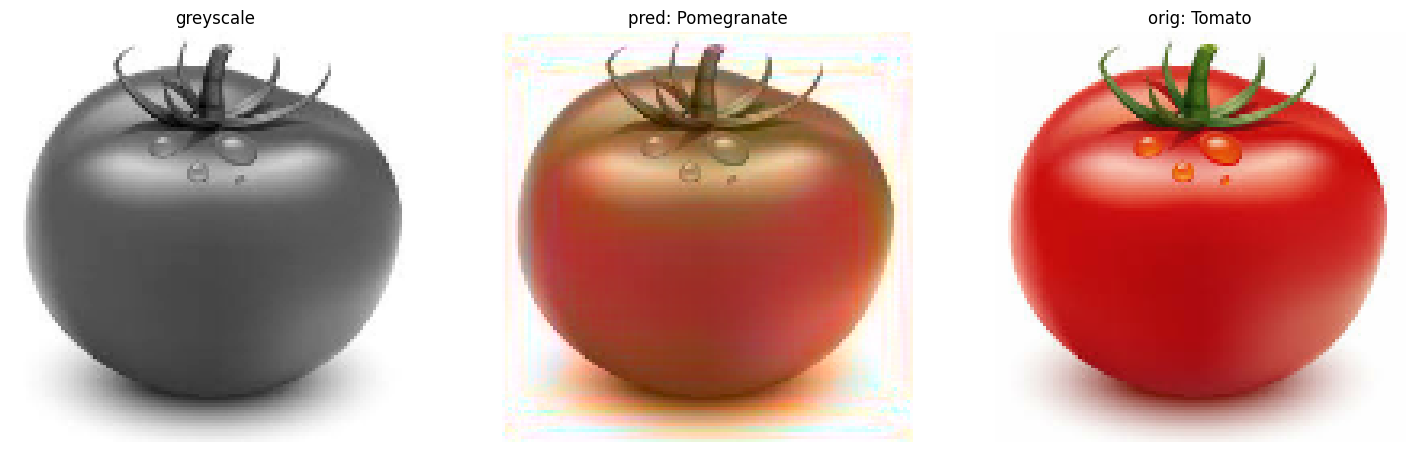

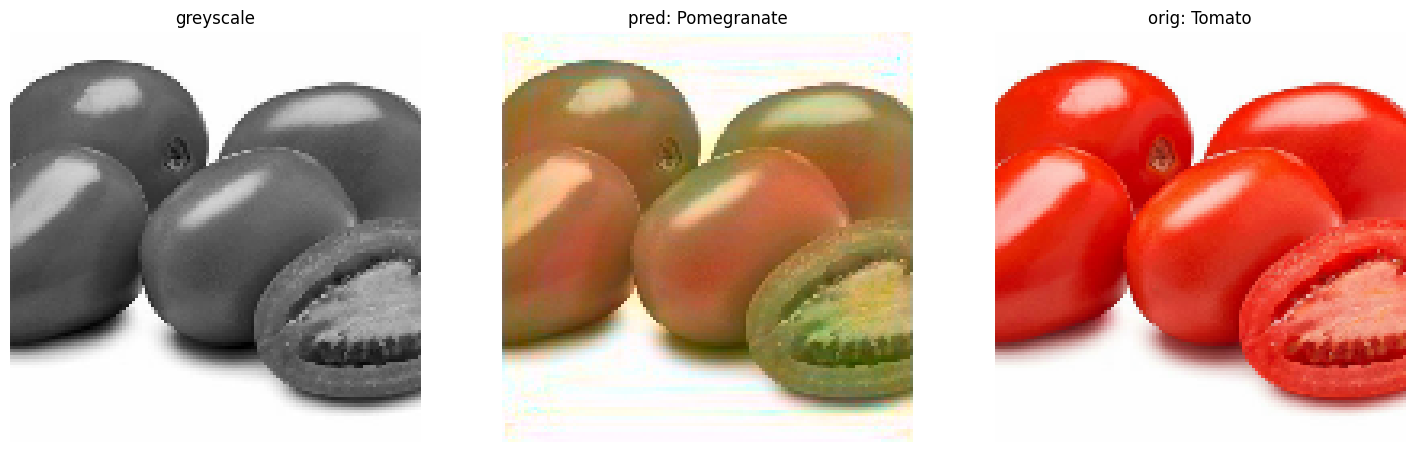

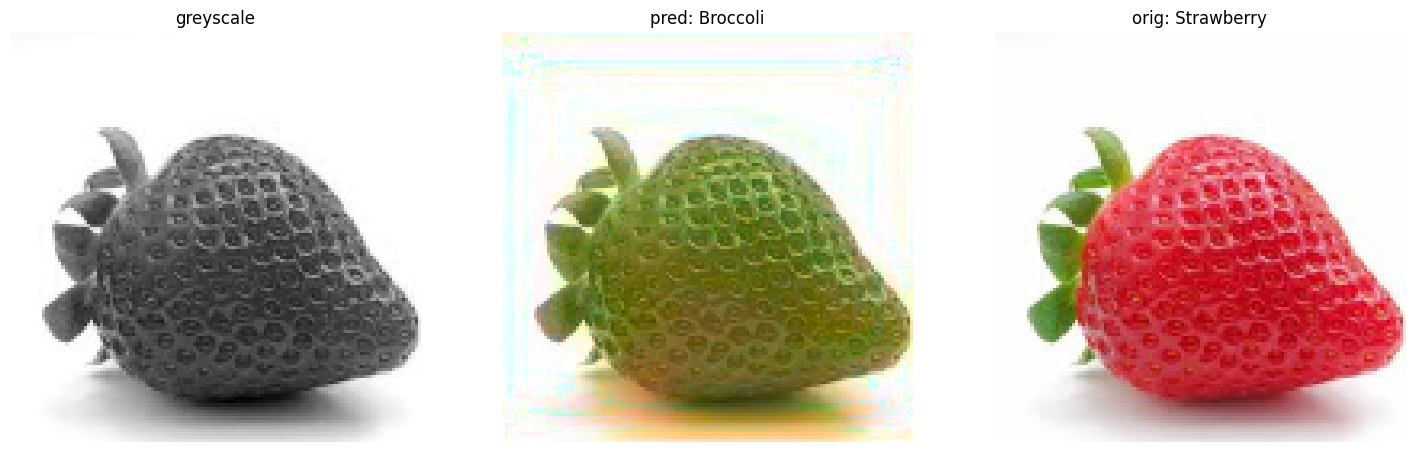

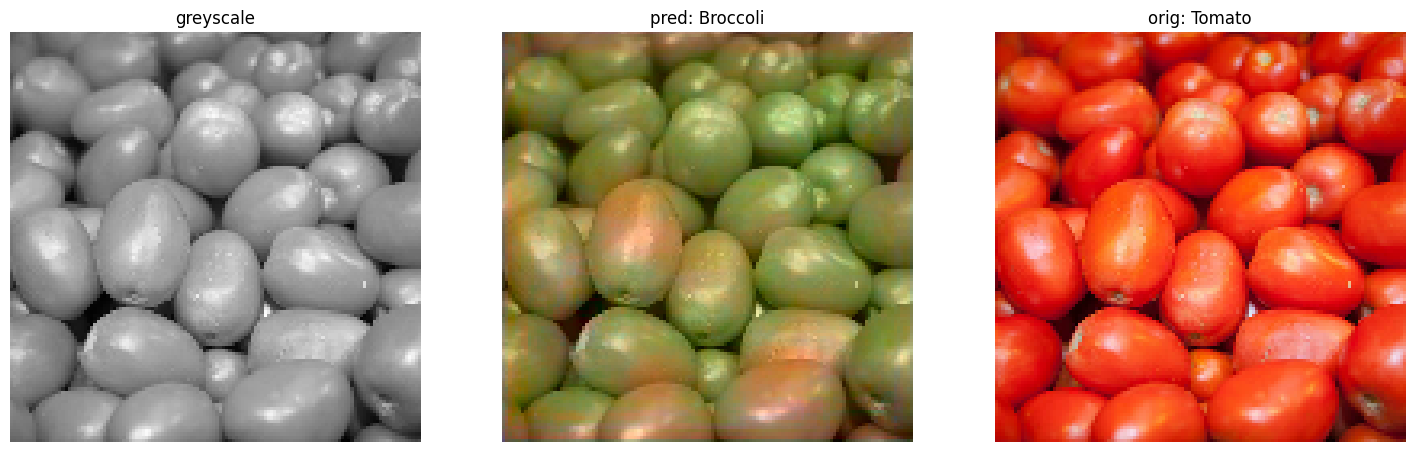

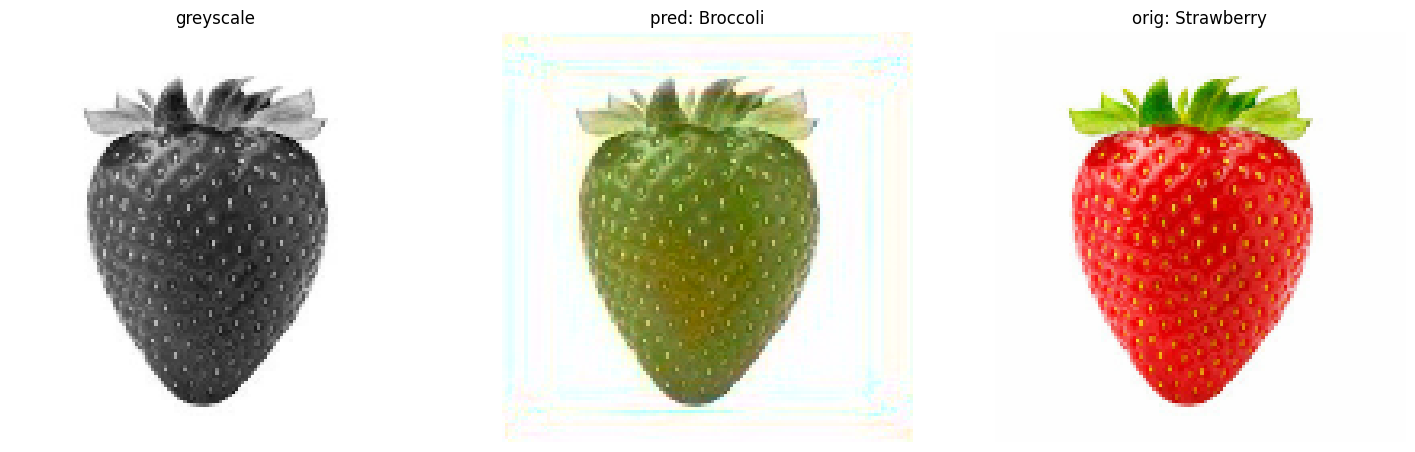

In [9]:
# visualize data examples with predicted and true colorization
for data in tqdm(test_data, position=0, leave=True):
    predicted_color, predicted_label = model00001.test_step(data)

    if random.random() < 1:
        visualize(predicted_color[0], predicted_label[0], data, class_names)


In [ ]:
# train and test single-task classification model
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_classification = Only_Classification_Model(optimizer=optimizer, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/classification/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/classification/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop_classification(only_classification, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)

In [ ]:
# train and test single-task colorization model
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_colorization = Only_Colorization_Model(optimizer=optimizer, loss_function_color=loss_function_color)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/colorization/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/colorization/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop_colorization(only_colorization, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


In [ ]:
# visualize data examples with predicted and true colorization
for data in tqdm(test_data, position=0, leave=True):
    predicted_color = only_colorization.test_step(data)

    if random.random() < 1:
        visualize(predicted_color[0], data[1][0], data)